# 주제명: Autoencoder 기반의 잠재 벡터를 바탕으로 한 고객 데이터 분류를 통한 페르소나 맞춤형 포트폴리오 최적화 서비스

### 팀명: Fine Bigdata Analysts (FBA)
### 팀원1: 구본우 (KAIST 산업및시스템공학과)
### 팀원2: 최인수 (KAIST 산업및시스템공학과)
### 팀원3: 고우성 (Yonsei University 경제학과 컴퓨터과학과)
### Github: github.com/reiss-koh/nh

## Raw Data Rename

#### cus_ifo.csv → cus_info.xlsx
#### kr_stk_orr.csv → kr_equity.xlsx
#### oss_stk_orr.csv → os_equity.xlsx
#### cus_tot_aet_ifo.csv → cus_assets.xlsx
#### cus_itg_sct_bnc.csv → cus_account.xlsx

## Import Packages 



In [ ]:
import pandas as pd
import numpy as np
from numpy import nan
from scipy import stats
from datetime import date, datetime
import investpy
from pandas_datareader import data as pdr
from pandas_profiling import ProfileReport

import os
import csv
import sys
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq
from sklearn.manifold import TSNE

## Descriptive Statistics & EDA for Raw Data




In [ ]:
df1 = pd.read_csv('./data/cus_ifo.csv')
df2 = pd.read_csv('./data/cus_itg_sct_bnc.csv')
df3 = pd.read_csv('./data/cus_tot_aet_ifo.csv')
df4 = pd.read_csv('./data/kr_stk_orr.csv')
df5 = pd.read_csv('./data/oss_stk_orr.csv')

In [ ]:
profile1 = ProfileReport(df1, title="Report")
profile2 = ProfileReport(df2, title="Report")
profile3 = ProfileReport(df3, title="Report")
profile4 = ProfileReport(df4, title="Report")
profile5 = ProfileReport(df5, title="Report")

In [ ]:
profile1.to_file("./data/profiles/cus_ifo.html")
profile2.to_file("./data/profiles/cus_itg_sct_bnc.html")
profile3.to_file("./data/profiles/cus_tot_aet_ifo.html")
profile4.to_file("./data/profiles/kr_stk_orr.html")
profile5.to_file("./data/profiles/oss_stk_orr.html")

## Global Config


In [ ]:
pd.set_option("display.max_columns", None)
os.environ["OMP_NUM_THREADS"] = '1'

## Global Functions

In [ ]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

def most_frequent(list):
    return max(set(list), key = list.count)

def can_convert_to_int(string):
    try:
        int(string)
        return True
    except ValueError:
        return False

## Global Tuples

In [ ]:
RAW_DATA = ("cus_info",
            "cus_account")

RAW_DATA1 = ("kr_equity",
             "os_equity")

DATA_PATH = ("kr_equity",
             "os_equity",
             "cus_account")

DATA_PATH1 = ("os_equity",
              "cus_account")

DATA_PATH2 = ("cus_account_R3",
              "cus_assets_R1",
              "kr_equity_R2",
              "os_equity_R3")

DATA_PATH3 = ("cus_account",
              "cus_assets",
              "kr_equity",
              "os_equity")

DATA_PATH4 = ("cus_account_R5",
              "cus_assets_R5",
              "kr_equity_R5",
              "os_equity_R5",
              "cus_info_R3")

ASSET_COLUMNS = ("tot_aet_tld_rnd_202201",
                 "tot_aet_tld_rnd_202202",
                 "tot_aet_tld_rnd_202203",
                 "tot_aet_tld_rnd_202204",
                 "tot_aet_tld_rnd_202205",
                 "tot_aet_tld_rnd_202206")

MODE_COLUMNS = ("act_no",
                "mts_mm_access_type",
                "SEX_F",
                "SEX_M",
                "SEX_NA",
                "cus_age_stn_cd",
                "pft_amt_stn_cd",
                "fst_act_opn_dt",
                "LIFESTAGE_1",
                "LIFESTAGE_2",
                "LIFESTAGE_3",
                "LIFESTAGE_4",
                "LIFESTAGE_5",
                "LIFESTAGE_6",
                "LIFESTAGE_7",
                "LIFESTAGE_8",
                "LIFESTAGE_9",
                "LIFESTAGE_10",
                "LIFESTAGE_NA",
                "tco_cus_grd_cd",
                "tot_ivs_te_sgm_cd",
                "HOLDINGS_TYPE_1.0",
                "HOLDINGS_TYPE_2.0",
                "HOLDINGS_TYPE_3.0",
                "HOLDINGS_TYPE_4.0",
                "HOLDINGS_TYPE_NA",
                "loy_sgm_cd",
                "SECTOR_1.0",
                "SECTOR_2.0",
                "SECTOR_3.0",
                "SECTOR_4.0",
                "SECTOR_5.0",
                "SECTOR_6.0",
                "SECTOR_7.0",
                "SECTOR_8.0",
                "SECTOR_9.0",
                "SECTOR_10.0",
                "SECTOR_11.0",
                "SECTOR_12.0",
                "SECTOR_13.0",
                "SECTOR_14.0",
                "SECTOR_15.0",
                "SECTOR_16.0")

MAX_COLUMNS = ("stk_pdt_hld_yn",
               "ose_stk_pdt_hld_yn",
               "mrz_pdt_tp_sgm_cd",
               "mrz_mkt_dit_cd",
               "aet_bse_stk_trd_tp_cd",
               "bas_stk_trd_tp_cd")

DROP_COLUMNS = ("stl_bse_itg_bnc_qty",
                "stl_bse_fc_now_eal_amt",
                "itg_byn_cns_qty",
                "itg_sll_cns_qty",
                "cns_bse_itg_bnc_qty",
                "cns_bse_now_eal_amt",
                "cns_bse_fc_now_eal_amt")

## Data Process Parent Class

In [ ]:
class DataProcess(object):
    def __init__(self, data_path, excel_or_csv="", data_path1="", data_path2="", data_path3="", data_path4="",
                 data_path5="", data_path6="", data_path7="", data_path8="", data_path9=""):

        if excel_or_csv == "csv":
            self.df = pd.read_csv(data_path, sep=',', encoding='unicode_escape')
            self.df_list = [self.df]
            if data_path1 != "":
                self.df1 = pd.read_csv(data_path1, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df1)
            if data_path2 != "":
                self.df2 = pd.read_csv(data_path2, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df2)
            if data_path3 != "":
                self.df3 = pd.read_csv(data_path3, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df3)
            if data_path4 != "":
                self.df4 = pd.read_csv(data_path4, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df4)
            if data_path5 != "":
                self.df5 = pd.read_csv(data_path5, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df5)
            if data_path6 != "":
                self.df6 = pd.read_csv(data_path6, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df6)
            if data_path7 != "":
                self.df7 = pd.read_csv(data_path7, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df7)
            if data_path8 != "":
                self.df8 = pd.read_csv(data_path8, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df8)
            if data_path9 != "":
                self.df9 = pd.read_csv(data_path9, sep=',', encoding='unicode_escape')
                self.df_list.append(self.df9)
        else:
            self.df = pd.read_excel(data_path)
            self.df_list = [self.df]
            if data_path1 != "":
                self.df1 = pd.read_excel(data_path1)
                self.df_list.append(self.df1)
            if data_path2 != "":
                self.df2 = pd.read_excel(data_path2)
                self.df_list.append(self.df2)
            if data_path3 != "":
                self.df3 = pd.read_excel(data_path3)
                self.df_list.append(self.df3)
            if data_path4 != "":
                self.df4 = pd.read_excel(data_path4)
                self.df_list.append(self.df4)
            if data_path5 != "":
                self.df5 = pd.read_excel(data_path5)
                self.df_list.append(self.df5)
            if data_path6 != "":
                self.df6 = pd.read_excel(data_path6)
                self.df_list.append(self.df6)
            if data_path7 != "":
                self.df7 = pd.read_excel(data_path7)
                self.df_list.append(self.df7)
            if data_path8 != "":
                self.df8 = pd.read_excel(data_path8)
                self.df_list.append(self.df8)
            if data_path9 != "":
                self.df9 = pd.read_excel(data_path9)
                self.df_list.append(self.df9)

        self.df_len = len(self.df)

    # dfs: data frames
    # dps: data paths
    def export(self, dps, excel_or_csv=""):
        if len(dps) == len(self.dfs):

            if excel_or_csv == "csv":
                for i in range(len(self.dfs)):
                    self.dfs[i].to_csv(dps[i])
                print("Exported To:", dps)

            else:
                for i in range(len(self.dfs)):
                    self.dfs[i].to_excel(dps[i])
                print("Exported To:", dps)

        else:
            print("Incorrect Number of Data Paths")
            print("Data Paths: ", len(dps))
            print("Data Frames: ", len(self.dfs))

## EDA and Visualization



## Data Processing Logic
### After checking that each customer maps to a unique account, we map all other features based on customers' accounts. 

### We ensure that the machine learning algorithm does not learn spurious relationships due to the data. First, for all categorical data, we one hot encode them. Next, we appropriately handle non-available or "99" data points. Also, we handle symbolic numeric values such as "mts_mm_access_type: 110000" appropriately to proxy and represent the underlying feature. This is also the case for some dates.
### We notice that there are some provided columns representing the same feature. We choose to omit the less accurate column for the column that best represents the customer's feature. We also omit features discretionarily through domain knowledge when we believe the signal(insight) to noise ratio is very low.
### We discretionary group certain sets of values to proxy for a feature we believe is more meaningful than the non-processed column. This helps cluster the data into sociodemographic personas, which provides meaningful insight for customer targeting. 
### For intuitiveness, we reverse-order some numerically labeled features as we must look back at the features post-clustering.
### We take a cross-sectional approach to our clustering instead of using a machine learning model suited for time-series. Therefore, we find an appropriate aggregation or representation method when transforming the time-series data into cross-sectional. We assume that six-month-month changes do not provide meaningful insight for a clustering algorithm. 
### We introduce new data in relation to existing observations and features, allowing us to create a new feature, "Value Weighted Volatility" that improves our understanding of the customers.
### Lastly, we handle outliers, then scale data through the MinMax approach.


## Data Process Classes

#### Check if Each Customer Maps to Unique Account

In [ ]:
class customerAccount(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        self.df = self.df[["cus_no", "act_no"]]

        memory = {}

        for i in range(len(self.df)):
            if self.df.loc[i]["cus_no"] not in memory:
                memory[self.df.loc[i]["cus_no"]] = [self.df.loc[i]["act_no"]]
            elif self.df.loc[i]["cus_no"] in memory:
                if self.df.loc[i]["act_no"] not in memory[self.df.loc[i]["cus_no"]]:
                    memory[self.df.loc[i]["cus_no"]].append(self.df.loc[i])

        self.df1 = pd.DataFrame()
        self.df1["Customer"] = ["_"] * len(memory)
        self.df1["Account Number"] = ["_"] * len(memory)

        j = 0
        for key, value in memory.items():
            self.df1.at[j, "Customer"] = key
            self.df1.at[j, "Account Number"] = len(value)
            j += 1

        for i in range(len(self.df1)):
            if self.df1.loc[i]["Account Number"] != 1:
                print("Not 1 Found")

        self.dfs = [self.df1]

#### Reorder Time Series Observations (Rows) in Chronological Order for each Account

In [ ]:
class chronological2(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self, sort_by="bse_ym"):
        self.df_output = pd.DataFrame()
        current_acc = ""
        for i in range(self.df_len):
            print(i)
            if current_acc == "":
                current_acc = self.df.loc[i]["act_no"]
                indicies = [0]
            elif current_acc == self.df.loc[i]["act_no"]:
                indicies.append(i)
            elif current_acc != self.df.loc[i]["act_no"]:

                self.df1 = pd.DataFrame()
                self.df1 = self.df.iloc[indicies, :]
                self.df1 = self.df1.sort_values(by=sort_by, ascending=True)
                self.df_output = self.df_output.append(self.df1, ignore_index=True)

                current_acc = self.df.loc[i]["act_no"]
                indicies = [i]

            if i == self.df_len - 1:
                self.df1 = pd.DataFrame()
                self.df1 = self.df.iloc[indicies, :]
                self.df1 = self.df1.sort_values(by=sort_by, ascending=True)
                self.df_output = self.df_output.append(self.df1, ignore_index=True)

        self.dfs = [self.df_output]

#### Map Y/N to 1/0

In [ ]:
class yesNo(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self, columns=[]):
        for column in columns:
            for i in range(self.df_len):
                print(i)
                if self.df.loc[i][column] == "Y":
                    self.df.at[i, column] = 1
                elif self.df.loc[i][column] == "N":
                    self.df.at[i, column] = 0

        self.dfs = [self.df]

#### Check Number of Unique Currencies in Data

In [ ]:
class uniqueFX(DataProcess):
    def __init__(self, data_path, data_path1, excel_or_csv=""):
        super().__init__(data_path=data_path, data_path1=data_path1, excel_or_csv=excel_or_csv)

    def process(self, column=""):
        unique_fx = []

        for i in range(self.df_len):
            if self.df.loc[i][column] not in unique_fx:
                unique_fx.append(self.df.loc[i][column])

        for i in range(len(self.df1)):
            if self.df1.loc[i][column] not in unique_fx:
                unique_fx.append(self.df1.loc[i][column])

        for fx in unique_fx:
            print(fx)

        self.dfs = [self.df]

#### Rename Customers and Accounts

In [ ]:
class renameCusAcc(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        current_cus = ""
        current_acc = ""
        j = 0
        acc_dict = {}

        for i in range(self.df_len):
            print(i)
            if current_cus == "" and current_acc == "":
                current_cus = self.df.loc[i]["cus_no"]
                current_acc = self.df.loc[i]["act_no"]
                acc_dict[self.df.loc[i]["act_no"]] = "acc_" + str(j)

                self.df.at[i, "cus_no"] = "cus_" + str(j)
                self.df.at[i, "act_no"] = "acc_" + str(j)
            elif current_cus == self.df.loc[i]["cus_no"] and current_acc == self.df.loc[i]["act_no"]:
                self.df.at[i, "cus_no"] = "cus_" + str(j)
                self.df.at[i, "act_no"] = "acc_" + str(j)
            elif current_cus != self.df.loc[i]["cus_no"] and current_acc != self.df.loc[i]["act_no"]:
                current_cus = self.df.loc[i]["cus_no"]
                current_acc = self.df.loc[i]["act_no"]

                j += 1

                acc_dict[self.df.loc[i]["act_no"]] = "acc_" + str(j)

                self.df.at[i, "cus_no"] = "cus_" + str(j)
                self.df.at[i, "act_no"] = "acc_" + str(j)

        self.dfs = [self.df]

        return acc_dict

#### Rename Accounts
#### Drop Customers Since Each Account Observation Maps to a Unique Customer Observation

In [ ]:
class renameCusAcc1(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self, acc_dict={}):
        for i in range(self.df_len):
            print(i)
            self.df.at[i, "act_no"] = acc_dict[self.df.loc[i, "act_no"]]

        self.dfs = [self.df]


class renameCusAcc2(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self, acc_dict={}):
        self.df.drop("cus_no", axis=1, inplace=True)

        for i in range(self.df_len):
            print(i)
            self.df.at[i, "act_no"] = acc_dict[self.df.loc[i, "act_no"]]

        self.dfs = [self.df]

#### One Hot Encode FX 

In [ ]:
class oneHotFX(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        self.df1 = pd.get_dummies(self.df.cur_cd, prefix='FX')
        self.df = pd.concat([self.df, self.df1], axis=1)

        self.df.drop("cur_cd", axis=1, inplace=True)

        self.dfs = [self.df]

#### Order Accounts Ascending for All Files

In [ ]:
class accToNum(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self, drop=""):

        if drop != "":
            self.df = self.df.drop([drop], axis=1)

        for i in range(self.df_len):
            print(i)
            self.df.at[i, "act_no"] = int(self.df.loc[i]["act_no"][4:])

        self.dfs = [self.df]


class sortByAcc(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        self.df = self.df.sort_values(by="act_no", ascending=True, kind="mergesort")  # mergesort is stable

        self.dfs = [self.df]

#### Remove Unnecessary Index Columns

In [ ]:
class dropUnnamed(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):

        for column in self.df:
            if "Unnamed" in column:
                self.df = self.df.drop([column], axis=1)

        self.dfs = [self.df]

#### Aggregate Monthly Access Count to Representative Integer
#### e.g. “110000” → “2”, “111111” → “6”

In [ ]:
class monthlyAccessCount(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            print(i)
            arr = list(str(self.df.loc[i]["mts_mm_access_type"]))

            sum = 0
            for j in arr:
                sum += int(j)

            self.df.at[i, "mts_mm_access_type"] = sum

        self.dfs = [self.df]

#### One Hot Encode Sex

In [ ]:
class oneHotSex(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        pd.set_option("display.max_columns", None)
        for i in range(self.df_len):

            if self.df.loc[i]["sex_dit_cd"] == 1:
                self.df.at[i, "sex_dit_cd"] = "M"
            elif self.df.loc[i]["sex_dit_cd"] == 2:
                self.df.at[i, "sex_dit_cd"] = "F"
            elif self.df.loc[i]["sex_dit_cd"] == 99:
                self.df.at[i, "sex_dit_cd"] = "NA"

        self.df1 = pd.get_dummies(self.df.sex_dit_cd, prefix='SEX')
        self.df = pd.concat([self.df, self.df1], axis=1)

        self.df.drop("sex_dit_cd", axis=1, inplace=True)

        self.dfs = [self.df]

#### Set Age = 99 to "NA"

In [ ]:
class processAge(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            if self.df.loc[i]["cus_age_stn_cd"] == 99:
                self.df.at[i, "cus_age_stn_cd"] = "NA"

        self.dfs = [self.df]

#### Regroup Main Traded Security to Proxy for Customer Risk Profile
#### 01 Low Risk = {ONLY_CMA, 신용대출, WRAP, MMW, 발행어음, RP, 신탁_퇴직연금}
#### 02 Mid Risk = {ELS_DLS, 펀드, 국내채권, 해외채권}
#### 03 High Risk = {국내주식, 해외주식, 선물옵션, 금속}
#### NA = {99}


In [ ]:
class regroupSecurity(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        low_risk = [1, 15, 14, 13, 12, 11, 10]
        mid_risk = [9, 8, 7, 6]
        high_risk = [5, 4, 3, 2]
        na = [99]

        for i in range(self.df_len):
            print(i)
            if self.df.loc[i]["mrz_pdt_tp_sgm_cd"] in low_risk:
                self.df.at[i, "mrz_pdt_tp_sgm_cd"] = 1
            elif self.df.loc[i]["mrz_pdt_tp_sgm_cd"] in mid_risk:
                self.df.at[i, "mrz_pdt_tp_sgm_cd"] = 2
            elif self.df.loc[i]["mrz_pdt_tp_sgm_cd"] in high_risk:
                self.df.at[i, "mrz_pdt_tp_sgm_cd"] = 3
            elif self.df.loc[i]["mrz_pdt_tp_sgm_cd"] in na:
                self.df.at[i, "mrz_pdt_tp_sgm_cd"] = "NA"

        self.dfs = [self.df]

#### Set Lifestage = "99" to "NA"
#### One Hot Encode

In [ ]:
class lifestageProcess(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            if self.df.loc[i]["lsg_sgm_cd"] == 99:
                self.df.at[i, "lsg_sgm_cd"] = "NA"

        self.df1 = pd.get_dummies(self.df.lsg_sgm_cd, prefix='LIFESTAGE')
        self.df = pd.concat([self.df, self.df1], axis=1)

        self.df.drop("lsg_sgm_cd", axis=1, inplace=True)

        self.dfs = [self.df]

#### Reverse Numerical Labeling for Intuitive Interpretation

In [ ]:
class customerLvlProcess(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        dictionary = {1: 7,
                      2: 6,
                      3: 5,
                      4: 4,
                      5: 3,
                      9: 2,
                      99: 1}

        for i in range(self.df_len):
            self.df.at[i, "tco_cus_grd_cd"] = dictionary[self.df.loc[i]["tco_cus_grd_cd"]]

        self.dfs = [self.df]

#### Set Total Investing Duration = "99" to "NA"

In [ ]:
class totalDurationInvestingProcess(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            if self.df.loc[i]["tot_ivs_te_sgm_cd"] == 99:
                self.df.at[i, "tot_ivs_te_sgm_cd"] = "NA"

        self.dfs = [self.df]

#### Set Holdings Type = "99" to "NA"
#### One Hot Encode

In [ ]:
class holdingsTypeProcessing(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            if self.df.loc[i]["hld_pdt_tp_sgm_cd"] == 99:
                self.df.at[i, "hld_pdt_tp_sgm_cd"] = "NA"

        self.df1 = pd.get_dummies(self.df.hld_pdt_tp_sgm_cd, prefix='HOLDINGS_TYPE')
        self.df = pd.concat([self.df, self.df1], axis=1)

        self.df.drop("hld_pdt_tp_sgm_cd", axis=1, inplace=True)

        self.dfs = [self.df]

#### Set Loyalty = "99" to "NA"
#### Reverse Numerical Labeling for Intuitive Interpretation

In [ ]:
class loyaltyProcess(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):

        dictionary = {1: 6,
                      2: 5,
                      3: 4,
                      4: 3,
                      5: 2,
                      6: 1}

        for i in range(self.df_len):
            print(i)
            if self.df.loc[i]["loy_sgm_cd"] == 99:
                self.df.at[i, "loy_sgm_cd"] = "NA"
            elif self.df.loc[i]["loy_sgm_cd"] in dictionary:
                self.df.at[i, "loy_sgm_cd"] = dictionary[self.df.loc[i]["loy_sgm_cd"]]
            else:
                self.df.at[i, "loy_sgm_cd"] = "NA"

        self.dfs = [self.df]

#### Set Main Market = "99" to "NA"
#### Regroup Main Market to Proxy for Customer Sophistication
#### 01 Low Sophistication = {비매매}
#### 02 Mid Sophistication = {거래소, 코스닥, 외화주식}
#### 03 High Sophistication = {혼합}
#### 04 Very High Sophistication = {ELW}


In [ ]:
class mainMarketProcess(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        low_soph = [6]
        mid_soph = [1, 2, 4]
        high_soph = [5]
        vhigh_soph = [3]

        for i in range(self.df_len):
            if self.df.loc[i]["mrz_mkt_dit_cd"] == 99:
                self.df.at[i, "mrz_mkt_dit_cd"] = "NA"
            elif self.df.loc[i]["mrz_mkt_dit_cd"] in low_soph:
                self.df.at[i, "mrz_mkt_dit_cd"] = 1
            elif self.df.loc[i]["mrz_mkt_dit_cd"] in mid_soph:
                self.df.at[i, "mrz_mkt_dit_cd"] = 2
            elif self.df.loc[i]["mrz_mkt_dit_cd"] in high_soph:
                self.df.at[i, "mrz_mkt_dit_cd"] = 3
            elif self.df.loc[i]["mrz_mkt_dit_cd"] in vhigh_soph:
                self.df.at[i, "mrz_mkt_dit_cd"] = 4

        self.dfs = [self.df]

#### Set Main Sector = "99" to "NA"
#### One Hot Encode

In [ ]:
class mainSectorProcess(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):

        for i in range(self.df_len):
            if self.df.loc[i]["mrz_btp_dit_cd"] == 99:
                self.df.at[i, "mrz_btp_dit_cd"] = "NA"

        self.df1 = pd.get_dummies(self.df.mrz_btp_dit_cd, prefix='SECTOR')
        self.df = pd.concat([self.df, self.df1], axis=1)

        self.df.drop("mrz_btp_dit_cd", axis=1, inplace=True)

        self.dfs = [self.df]

#### Set Net Worth = "99" to "NA"
#### Reverse Numerical Labeling for Intuitive Interpretation

In [ ]:
class netWorthProcess(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):

        dictionary = {1: 5,
                      2: 4,
                      3: 3,
                      4: 2,
                      5: 1}

        for i in range(self.df_len):
            if self.df.loc[i]["aet_bse_stk_trd_tp_cd"] == 99 or self.df.loc[i]["aet_bse_stk_trd_tp_cd"] == "_":
                self.df.at[i, "aet_bse_stk_trd_tp_cd"] = "NA"
            elif self.df.loc[i]["aet_bse_stk_trd_tp_cd"] in dictionary:
                self.df.at[i, "aet_bse_stk_trd_tp_cd"] = dictionary[self.df.loc[i]["aet_bse_stk_trd_tp_cd"]]
            else:
                self.df.at[i, "aet_bse_stk_trd_tp_cd"] = "NA"

        self.dfs = [self.df]

#### Set Trade Frequency = "99" to "NA"
#### Reverse Numerical Labeling for Intuitive Interpretation

In [ ]:
class tradeFrequencyProcess(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):

        dictionary = {1: 11,
                      2: 10,
                      3: 9,
                      4: 8,
                      5: 7,
                      6: 6,
                      7: 5,
                      8: 4,
                      9: 3,
                      10: 2,
                      11: 1}

        for i in range(self.df_len):
            if self.df.loc[i]["bas_stk_trd_tp_cd"] == 99:
                self.df.at[i, "bas_stk_trd_tp_cd"] = "NA"
            if can_convert_to_int(self.df.loc[i]["bas_stk_trd_tp_cd"]):
                self.df.at[i, "bas_stk_trd_tp_cd"] = dictionary[int(self.df.loc[i]["bas_stk_trd_tp_cd"])]
            else:
                self.df.at[i, "bas_stk_trd_tp_cd"] = "NA"

        self.dfs = [self.df]

#### Drop Column Class 

In [ ]:
class dropColumn(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self, column_name="Unnamed"):
        self.df = self.df.drop([column_name], axis=1)

        self.dfs = [self.df]

#### Time Series to Cross Sectional by Taking Max Asset Value

In [ ]:
class maxAssetValue(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):

        for i in range(self.df_len):
            print(i)
            arr = []
            for column in ASSET_COLUMNS:
                if can_convert_to_int(self.df.loc[i][column]):
                    arr.append(self.df.loc[i][column])

            self.df.at[i, "MAX_ASSET_VALUE"] = max(arr)

        for column in ASSET_COLUMNS:
            self.df = self.df.drop([column], axis=1)

        self.dfs = [self.df]

#### Derive Account Lifespan from Account Open Date

In [ ]:
class accLifespan(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        today = date.today()

        for i in range(self.df_len):
            year = int(str(self.df.loc[i]["fst_act_opn_dt"])[0:4])
            month = int(str(self.df.loc[i]["fst_act_opn_dt"])[4:6])
            day = int(str(self.df.loc[i]["fst_act_opn_dt"])[6:8])

            dateObject = date(year, month, day)

            self.df.at[i, "fst_act_opn_dt"] = (today - dateObject).days

        self.dfs = [self.df]

#### Time Series to Cross Sectional by taking the Mode, for Customer Information CSV File
#### cross_sectional = mode(time_series): 

#### {act_no 계좌번호(가명화), 
#### mts_mm_access_type MTS월단위접속패턴,
#### sex_dit_cd 성별 (ONE HOT ENCODED),
#### cus_age_stn_cd 연령대,
#### pft_amt_stn_cd 수익금액구간코드,
#### fst_act_opn_dt 최초계좌개설일,
#### lsg_sgm_cd LIFESTAGE세그먼트코드 (ONE HOT ENCODED),
#### tco_cus_grd_cd 고객등급코드,
#### tot_ivs_te_sgm_cd 총투자기간세그먼트코드,
#### hld_pdt_tp_sgm_cd 보유상품유형세그먼트코드 (ONE HOT ENCODED),
#### loy_sgm_cd 충성도세그먼트코드,
#### mrz_btp_dit_cd 주거래업종구분코드 (ONE HOT ENCODED)}


In [ ]:
class infoToCrossSectMode(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):

        self.df1 = pd.DataFrame()

        for column_name in MODE_COLUMNS:
            current_acc = ""
            k = 0
            memory = []

            for i in range(self.df_len):
                print(column_name, i)

                if current_acc == "":
                    current_acc = self.df.loc[i]["act_no"]
                    memory.append(self.df.loc[i][column_name])
                elif self.df.loc[i]["act_no"] == current_acc:
                    memory.append(self.df.loc[i][column_name])
                elif self.df.loc[i]["act_no"] != current_acc:

                    self.df1.at[k, "act_no"] = current_acc
                    self.df1.at[k, column_name] = most_frequent(memory)

                    current_acc = self.df.loc[i]["act_no"]
                    memory = [self.df.loc[i][column_name]]

                    k += 1

                if i == self.df_len - 1:
                    self.df1.at[k, "act_no"] = current_acc
                    self.df1.at[k, column_name] = most_frequent(memory)

        self.dfs = [self.df1]

#### Time Series to Cross Sectional by taking Max, for Customer Information CSV File
#### cross_sectional = max(time_series):
 
#### {stk_pdt_hld_yn 주식상품보유여부,
#### ose_stk_pdt_hld_yn 해외주식상품보유여부,
#### mrz_pdt_tp_sgm_cd 주거래상품군,
#### mrz_mkt_dit_cd 주거래시장구분코드,
#### aet_bse_stk_trd_tp_cd 자산기준주식거래유형코드,
#### bas_stk_trd_tp_cd 기본주식거래유형코드}

In [ ]:
class infoToCrossSectMax(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):

        self.df1 = pd.DataFrame()

        for column_name in MAX_COLUMNS:
            current_acc = ""
            k = 0
            memory = []

            for i in range(self.df_len):
                print(column_name, i)

                if current_acc == "":
                    current_acc = self.df.loc[i]["act_no"]
                    memory.append(self.df.loc[i][column_name])
                elif self.df.loc[i]["act_no"] == current_acc:
                    memory.append(self.df.loc[i][column_name])
                elif self.df.loc[i]["act_no"] != current_acc:

                    self.df1.at[k, "act_no"] = current_acc
                    self.df1.at[k, column_name] = max(memory)

                    current_acc = self.df.loc[i]["act_no"]
                    memory = [self.df.loc[i][column_name]]

                    k += 1

                if i == self.df_len - 1:
                    self.df1.at[k, "act_no"] = current_acc
                    self.df1.at[k, column_name] = most_frequent(memory)

        self.dfs = [self.df1]

#### Concatenate Two Data Frames Class

In [ ]:
class concatDataframes(DataProcess):
    def __init__(self, data_path, data_path1, excel_or_csv=""):
        super().__init__(data_path=data_path, data_path1=data_path1, excel_or_csv=excel_or_csv)

    def process(self):
        self.df = pd.concat([self.df, self.df1], axis=1)

        self.dfs = [self.df]

#### Concatenate Two Data Frames Class with Specific Column

In [ ]:
class concatDataframes2(DataProcess):
    def __init__(self, data_path, data_path1, excel_or_csv=""):
        super().__init__(data_path=data_path, data_path1=data_path1, excel_or_csv=excel_or_csv)

    def process(self, column_name=""):
        self.df1 = self.df1[[column_name]]
        self.df = pd.concat([self.df, self.df1], axis=1)

        self.dfs = [self.df]

#### Concatenate Two Data Frames Class with Specific Columns

In [ ]:
class concatAll(DataProcess):
    def __init__(self, data_path, data_path1, data_path2, excel_or_csv=""):
        super().__init__(data_path=data_path, data_path1=data_path1, data_path2=data_path2, excel_or_csv=excel_or_csv)

    def process(self, path1_column="", path2_column="", path2_column1=""):
        self.df1 = self.df1[[path1_column]]
        self.df2 = self.df2[[path2_column, path2_column1]]

        self.df = pd.concat([self.df, self.df1, self.df2], axis=1)

        self.dfs = [self.df]

#### Remove White Space

In [ ]:
class removeWhiteSpace(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self, column_name=""):
        for i in range(self.df_len):

            self.df.at[i, column_name] = str(self.df.loc[i][column_name]).strip()

        self.dfs = [self.df]

#### ISIN to Ticker using investpy Package
#### 외부 데이터 사용:
#### "vol_3m" Column: Standard Deviation of Daily Log Normal Price Returns for Korean Securities with Historic 3 Month Rolling Window Annualized by a Factor of 250. Data Sourced Based on Date: 2020-12-31 to Avoid Look-ahead Bias. Data Sourced from S&P Capital IQ.

In [ ]:
class getTicker(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            if self.df.loc[i]["vol_3m"] == "_":
                print(i)
                try:
                    df = investpy.stocks.search_stocks(by='isin', value=str(self.df.loc[i]["iem_cd"]))
                    ticker = df.loc[0]['symbol']
                except:
                    ticker = "_"

                self.df.at[i, "new_ticker"] = ticker
            else:
                self.df.at[i, "new_ticker"] = "__"

        self.dfs = [self.df]

#### Drop Uneccesary Columns in Account CSV File

In [ ]:
class accountDrop(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for column in DROP_COLUMNS:
            self.df = self.df.drop([column], axis=1)

        self.dfs = [self.df]

#### Create "final_vol_3m" Column Which Combines "vol_3m" and "new_vol_3m"
#### 외부 데이터 사용:
#### "new_vol_3m" Column: Standard Deviation of Daily Log Normal Price Returns for Overseas Securities with Historic 3 Month Rolling Window Annualized by a Factor of 250. Data Sourced Based on Date: 2020-12-31 to Avoid Look-ahead Bias. Data Sourced from S&P Capital IQ.

In [ ]:
class finalVol3M(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            print(i)
            if isfloat(self.df.loc[i]["vol_3m"]):
                self.df.at[i, "final_vol_3m"] = self.df.loc[i]["vol_3m"]
            elif isfloat(self.df.loc[i]["new_vol_3m"]):
                self.df.at[i, "final_vol_3m"] = self.df.loc[i]["new_vol_3m"]
            else:
                self.df.at[i, "final_vol_3m"] = "_"

        self.dfs = [self.df]

#### Derive Value Weighted Portfolio Volatility to Proxy for Customer Risk Profile

In [ ]:
class valueWeightedVolatility(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        self.df1 = pd.DataFrame()
        value_memory = []
        volatility_memory = []

        current_acc = ""
        k = 0

        for i in range(self.df_len):
            print(i)
            if current_acc == "":
                current_acc = self.df.loc[i]["act_no"]
                if can_convert_to_int(self.df.loc[i]["stl_bse_now_eal_amt"]) and isfloat(self.df.loc[i]["final_vol_3m"]):
                    value_memory.append(self.df.loc[i]["stl_bse_now_eal_amt"])
                    volatility_memory.append(self.df.loc[i]["final_vol_3m"])
            elif self.df.loc[i]["act_no"] == current_acc:
                if can_convert_to_int(self.df.loc[i]["stl_bse_now_eal_amt"]) and isfloat(self.df.loc[i]["final_vol_3m"]):
                    value_memory.append(self.df.loc[i]["stl_bse_now_eal_amt"])
                    volatility_memory.append(self.df.loc[i]["final_vol_3m"])
            elif self.df.loc[i]["act_no"] != current_acc:
                self.df1.at[k, "act_no"] = current_acc

                if len(value_memory) > 0 and len(volatility_memory) > 0:
                    weight_list = []
                    sum = np.sum(value_memory)

                    for value in value_memory:
                        weight_list.append(value/sum)

                    value_weighted_volatility = 0
                    for j in range(len(volatility_memory)):
                        value_weighted_volatility += float(volatility_memory[j]) * float(weight_list[j])

                    self.df1.at[k, "value_weighted_volatility"] = value_weighted_volatility
                else:
                    self.df1.at[k, "value_weighted_volatility"] = "_"

                value_memory = []
                volatility_memory = []
                if can_convert_to_int(self.df.loc[i]["stl_bse_now_eal_amt"]) and isfloat(self.df.loc[i]["final_vol_3m"]):
                    value_memory.append(self.df.loc[i]["stl_bse_now_eal_amt"])
                    volatility_memory.append(self.df.loc[i]["final_vol_3m"])

                current_acc = self.df.loc[i]["act_no"]
                k += 1

            if i == self.df_len - 1:
                self.df1.at[k, "act_no"] = current_acc
                if can_convert_to_int(self.df.loc[i]["stl_bse_now_eal_amt"]) and isfloat(self.df.loc[i]["final_vol_3m"]):
                    value_memory.append(self.df.loc[i]["stl_bse_now_eal_amt"])
                    volatility_memory.append(self.df.loc[i]["final_vol_3m"])

                if len(value_memory) > 0 and len(volatility_memory) > 0:
                    weight_list = []
                    sum = np.sum(value_memory)

                    for value in value_memory:
                        weight_list.append(value / sum)

                    value_weighted_volatility = 0
                    for j in range(len(volatility_memory)):
                        value_weighted_volatility += float(volatility_memory[j]) * float(weight_list[j])

                    self.df1.at[k, "value_weighted_volatility"] = value_weighted_volatility
                else:
                    self.df1.at[k, "value_weighted_volatility"] = "_"

        self.dfs = [self.df1]

#### Aggregate Leverage for Each Account

In [ ]:
class aggregateLeverage(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        self.df1 = pd.DataFrame()
        leverage = 0

        current_acc = ""
        k = 0

        for i in range(self.df_len):
            print(i)
            if current_acc == "":
                leverage += float(self.df.loc[i]["lon_amt"])
                current_acc = self.df.loc[i]["act_no"]
            elif self.df.loc[i]["act_no"] == current_acc:
                leverage += float(self.df.loc[i]["lon_amt"])
            elif self.df.loc[i]["act_no"] != current_acc:
                self.df1.at[k, "act_no"] = current_acc
                self.df1.at[k, "leverage"] = leverage

                leverage = 0
                current_acc = self.df.loc[i]["act_no"]
                k += 1

            if i == self.df_len - 1:
                self.df1.at[k, "act_no"] = current_acc
                self.df1.at[k, "leverage"] = leverage

        self.dfs = [self.df1]

#### Drop Observations (Rows) with Missing Data 

In [ ]:
class dropMissingData(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            print(i)
            if self.df.loc[i]["cus_age_stn_cd"] == "_":
                self.df.drop(index=i, axis=0, inplace=True)
                continue
            if self.df.loc[i]["tot_ivs_te_sgm_cd"] == "_":
                self.df.drop(index=i, axis=0, inplace=True)
                continue
            if self.df.loc[i]["value_weighted_volatility"] == "_" or self.df.loc[i]["value_weighted_volatility"] == 0 or self.df.loc[i]["value_weighted_volatility"] == "0":
                self.df.drop(index=i, axis=0, inplace=True)
                continue

        self.df.reset_index(inplace=True)

        self.dfs = [self.df]

#### Process Observations (Rows) with Missing Data 

In [ ]:
class processMissingData(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        for i in range(self.df_len):
            print(i)
            if self.df.loc[i]["loy_sgm_cd"] == "_":
                self.df.at[i, "loy_sgm_cd"] = 1
            if self.df.loc[i]["mrz_pdt_tp_sgm_cd"] == "_":
                self.df.at[i, "mrz_pdt_tp_sgm_cd"] = 1
            if self.df.loc[i]["mrz_mkt_dit_cd"] == "_":
                self.df.at[i, "mrz_mkt_dit_cd"] = 1
            if self.df.loc[i]["aet_bse_stk_trd_tp_cd"] == "_":
                self.df.at[i, "aet_bse_stk_trd_tp_cd"] = 1
            if self.df.loc[i]["bas_stk_trd_tp_cd"] == "_":
                self.df.at[i, "bas_stk_trd_tp_cd"] = 1

        self.dfs = [self.df]

#### One Hot Encode Account Number

In [ ]:
class oneHotAccount(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        self.df1 = pd.get_dummies(self.df.act_no, prefix='ACCOUNT')
        self.df = pd.concat([self.df1, self.df], axis=1)

        self.df.drop("act_no", axis=1, inplace=True)

        self.dfs = [self.df]

#### MinMax Scale Features

In [ ]:
class minMaxScale(DataProcess):
    def __init__(self, data_path, excel_or_csv=""):
        super().__init__(data_path=data_path, excel_or_csv=excel_or_csv)

    def process(self):
        scaler = MinMaxScaler()

        columns_list = []
        for column in self.df:
            columns_list.append(column)

        self.df = pd.DataFrame(scaler.fit_transform(self.df), columns=columns_list)

        self.dfs = [self.df]

## Data Process Main

In [ ]:
process = customerAccount(data_path="cus_info.xlsx")
process.process()
process.export(["cus_acc.csv"], excel_or_csv="csv")

In [ ]:
for file_name in RAW_DATA:
    process1 = chronological2(data_path=file_name + ".xlsx")
    process1.process(sort_by="bse_ym")
    process1.export([file_name + "_R1.csv"], excel_or_csv="csv")

In [ ]:
for file_name in RAW_DATA1:
    process1 = chronological2(data_path=file_name + ".xlsx")
    process1.process(sort_by="orr_dt")
    process1.export([file_name + "_R1.csv"], excel_or_csv="csv")

In [ ]:
process2 = yesNo(data_path="cus_info_R1" + ".csv", excel_or_csv="csv")
process2.process(columns=["stk_pdt_hld_yn", "ose_stk_pdt_hld_yn"])
process2.export(["cus_info" + "_R2.csv"], excel_or_csv="csv")

In [ ]:
process3 = uniqueFX(data_path="os_equity_R1.csv", data_path1="cus_account_R1.csv", excel_or_csv="csv")
process3.process(column="cur_cd")

In [ ]:
process4 = renameCusAcc(data_path="cus_info_R2.csv", excel_or_csv="csv")
acc_dict = process4.process()
process4.export(["cus_info_R3.csv"], excel_or_csv="csv")

In [ ]:
for file_name in DATA_PATH:
    process5 = renameCusAcc1(data_path=file_name + "_R1.csv", excel_or_csv="csv")
    process5.process(acc_dict=acc_dict)
    process5.export([file_name + "_R2.csv"], excel_or_csv="csv")

In [ ]:
process6 = renameCusAcc2(data_path="cus_assets.xlsx")
process6.process(acc_dict=acc_dict)
process6.export(["cus_assets_R1.csv"], excel_or_csv="csv")

In [ ]:
for file_name in DATA_PATH1:
    process7 = oneHotFX(data_path=file_name + "_R2.csv", excel_or_csv="csv")
    process7.process()
    process7.export([file_name + "_R3.csv"], excel_or_csv="csv")

In [ ]:
for file_name in DATA_PATH2:
    process8 = accToNum(data_path=file_name + ".csv", excel_or_csv="csv")
    process8.process()
    process8.export([file_name[:-3] + "_R4.csv"], excel_or_csv="csv")

In [ ]:
for file_name in DATA_PATH3:
    process9 = sortByAcc(data_path=file_name + "_R4.csv", excel_or_csv="csv")
    process9.process()  # merge sort is used for stability
    process9.export([file_name + "_R5.csv"], excel_or_csv="csv")

In [ ]:
for file_name in DATA_PATH4:
    process10 = dropUnnamed(data_path=file_name + ".csv", excel_or_csv="csv")
    process10.process()
    process10.export([file_name[:-3] + "_R6.csv"], excel_or_csv="csv")

In [ ]:
process11 = accToNum(data_path="cus_info_R6" + ".csv", excel_or_csv="csv")
process11.process(drop="cus_no")
process11.export(["cus_info_R7.csv"], excel_or_csv="csv")

In [ ]:
process12 = monthlyAccessCount(data_path="cus_info_R7" + ".csv", excel_or_csv="csv")
process12.process()
process12.export(["cus_info_R8.csv"], excel_or_csv="csv")

In [ ]:
process13 = oneHotSex(data_path="cus_info_R8" + ".csv", excel_or_csv="csv")
process13.process()
process13.export(["cus_info_R9.csv"], excel_or_csv="csv")

In [ ]:
process14 = processAge(data_path="cus_info_R9" + ".csv", excel_or_csv="csv")
process14.process()
process14.export(["cus_info_R10.csv"], excel_or_csv="csv")

In [ ]:
process15 = regroupSecurity(data_path="cus_info_R10" + ".csv", excel_or_csv="csv")
process15.process()
process15.export(["cus_info_R11.csv"], excel_or_csv="csv")

In [ ]:
process16 = lifestageProcess(data_path="cus_info_R11" + ".csv", excel_or_csv="csv")
process16.process()
process16.export(["cus_info_R12.csv"], excel_or_csv="csv")

In [ ]:
process17 = totalDurationInvestingProcess(data_path="cus_info_R13" + ".csv", excel_or_csv="csv")
process17.process()
process17.export(["cus_info_R14.csv"], excel_or_csv="csv")

In [ ]:
process18 = holdingsTypeProcessing(data_path="cus_info_R14" + ".csv", excel_or_csv="csv")
process18.process()
process18.export(["cus_info_R15.csv"], excel_or_csv="csv")

In [ ]:
process19 = loyaltyProcess(data_path="cus_info_R15" + ".csv", excel_or_csv="csv")
process19.process()
process19.export(["cus_info_R16.csv"], excel_or_csv="csv")

In [ ]:
process20 = mainMarketProcess(data_path="cus_info_R16" + ".csv", excel_or_csv="csv")
process20.process()
process20.export(["cus_info_R17.csv"], excel_or_csv="csv")

In [ ]:
process21 = mainSectorProcess(data_path="cus_info_R17" + ".csv", excel_or_csv="csv")
process21.process()
process21.export(["cus_info_R18.csv"], excel_or_csv="csv")

In [ ]:
process22 = netWorthProcess(data_path="cus_info_R18" + ".csv", excel_or_csv="csv")
process22.process()
process22.export(["cus_info_R19.csv"], excel_or_csv="csv")

In [ ]:
process23 = tradeFrequencyProcess(data_path="cus_info_R19" + ".csv", excel_or_csv="csv")
process23.process()
process23.export(["cus_info_R20.csv"], excel_or_csv="csv")

In [ ]:
process24 = dropColumn(data_path="cus_assets_R6.csv", excel_or_csv="csv")
process24.process(column_name="mts_mm_access_type")
process24.export(["cus_assets_R7.csv"], excel_or_csv="csv")

In [ ]:
process25 = dropColumn(data_path="cus_account_R6.csv", excel_or_csv="csv")
process25.process(column_name="itg_pdt_tp_cd")
process25.export(["cus_account_R7.csv"], excel_or_csv="csv")

In [ ]:
process26 = maxAssetValue(data_path="cus_assets_R7.csv", excel_or_csv="csv")
process26.process()
process26.export(["cus_assets_R8.csv"], excel_or_csv="csv")

In [ ]:
process27 = dropColumn(data_path="cus_info_R20.csv", excel_or_csv="csv")
process27.process(column_name="cus_aet_stn_cd")
process27.export(["cus_info_R21.csv"], excel_or_csv="csv")

In [ ]:
process28 = accLifespan(data_path="cus_info_R21.csv", excel_or_csv="csv")
process28.process()
process28.export(["cus_info_R22.csv"], excel_or_csv="csv")

In [ ]:
process29 = dropUnnamed(data_path="cus_info_R22.csv", excel_or_csv="csv")
process29.process()
process29.export(["cus_info_R23.csv"], excel_or_csv="csv")

In [ ]:
process30 = infoToCrossSectMode(data_path="cus_info_R23.csv", excel_or_csv="csv")
process30.process()
process30.export(["cus_info_R23_mode.csv"], excel_or_csv="csv")

In [ ]:
process31 = infoToCrossSectMax(data_path="cus_info_R23.csv", excel_or_csv="csv")
process31.process()
process31.export(["cus_info_R23_max.csv"], excel_or_csv="csv")

In [ ]:
process32 = concatDataframes(data_path="cus_info_R23_mode.csv", data_path1="cus_info_R23_max.csv", excel_or_csv="csv")
process32.process()
process32.export(["cus_info_R24.csv"], excel_or_csv="csv")

In [ ]:
process33 = dropUnnamed(data_path="cus_info_R24.csv", excel_or_csv="csv")
process33.process()
process33.export(["cus_info_R25.csv"], excel_or_csv="csv")

In [ ]:
process34 = dropColumn(data_path="cus_account_R7.csv", excel_or_csv="csv")
process34.process(column_name="fc_sec_trd_nat_cd")
process34.export(["cus_account_R8.csv"], excel_or_csv="csv")

In [ ]:
process35 = removeWhiteSpace(data_path="cus_account_R8.csv", excel_or_csv="csv")
process35.process(column_name="iem_cd")
process35.export(["cus_account_R9.csv"], excel_or_csv="csv")

#### 외부 데이터 사용:
#### cus_account_R10.xlsx is cus_account_R9.csv concatenated with new  column "vol_3m", where non-available data is "_"

#### "vol_3m" Column: Standard Deviation of Daily Log Normal Price Returns for Korean Securities with Historic 3 Month Rolling Window Annualized by a Factor of 250. Data Sourced Based on Date: 2020-12-31 to Avoid Look-ahead Bias. Data Sourced from S&P Capital IQ.

#### "new_ticker" Column: Security Ticker Data Sourced from investpy Package.

In [ ]:
process36 = getTicker(data_path="cus_account_R10.xlsx")
process36.process()
process36.export(["cus_account_R11.csv"], excel_or_csv="csv")

#### 외부 데이터 사용:
#### cus_account_R12.xlsx is cus_account_R11.csv concatenated with new  column "new_vol_3m", where non-available data is "_"

#### "new_vol_3m" Column: Standard Deviation of Daily Log Normal Price Returns for Overseas Securities with Historic 3 Month Rolling Window Annualized by a Factor of 250. Data Sourced Based on Date: 2020-12-31 to Avoid Look-ahead Bias. Data Sourced from S&P Capital IQ.

In [ ]:
process37 = accountDrop(data_path="cus_account_R12.xlsx")
process37.process()
process37.export(["cus_account_R13.csv"], excel_or_csv="csv")

In [ ]:
process38 = dropUnnamed(data_path="cus_account_R13.csv", excel_or_csv="csv")
process38.process()
process38.export(["cus_account_R14.csv"], excel_or_csv="csv")

In [ ]:
process39 = finalVol3M(data_path="cus_account_R14.csv", excel_or_csv="csv")
process39.process()
process39.export(["cus_account_R15.csv"], excel_or_csv="csv")

In [ ]:
process40 = valueWeightedVolatility(data_path="cus_account_R15.csv", excel_or_csv="csv")
process40.process()
process40.export(["cus_account_R16.csv"], excel_or_csv="csv")

In [ ]:
process41 = aggregateLeverage(data_path="cus_account_R15.csv", excel_or_csv="csv")
process41.process()
process41.export(["cus_account_R17.csv"], excel_or_csv="csv")

In [ ]:
process42 = concatDataframes2(data_path="cus_account_R16.csv", data_path1="cus_account_R17.csv", excel_or_csv="csv")
process42.process(column_name="leverage")
process42.export(["cus_account_R18.csv"], excel_or_csv="csv")

In [ ]:
process43 = concatAll(data_path="cus_info_R25.csv", data_path1="cus_assets_R8.csv", data_path2="cus_account_R18.csv", excel_or_csv="csv")
process43.process(path1_column="MAX_ASSET_VALUE", path2_column="value_weighted_volatility", path2_column1="leverage")
process43.export(["all_R1.csv"], excel_or_csv="csv")

#### All Empty (NaN) Cells in "all_R1.csv" are Replaced With "_" on Excel Due to Computational Efficiency

In [ ]:
process44 = dropColumn(data_path="all_R1.csv", excel_or_csv="csv")
process44.process(column_name="SEX_NA")
process44.export(["all_R2.csv"], excel_or_csv="csv")

In [ ]:
process45 = dropColumn(data_path="all_R2.csv", excel_or_csv="csv")
process45.process(column_name="LIFESTAGE_NA")
process45.export(["all_R3.csv"], excel_or_csv="csv")

In [ ]:
process46 = dropColumn(data_path="all_R3.csv", excel_or_csv="csv")
process46.process(column_name="HOLDINGS_TYPE_NA")
process46.export(["all_R4.csv"], excel_or_csv="csv")

In [ ]:
process47 = dropColumn(data_path="all_R4.csv", excel_or_csv="csv")
process47.process(column_name="act_no.1")
process47.export(["all_R5.csv"], excel_or_csv="csv")

In [ ]:
process48 = dropMissingData(data_path="all_R5.csv", excel_or_csv="csv")
process48.process()
process48.export(["all_R6.csv"], excel_or_csv="csv")

In [ ]:
process49 = processMissingData(data_path="all_R6.csv", excel_or_csv="csv")
process49.process()
process49.export(["all_R7.csv"], excel_or_csv="csv")

In [ ]:
process50 = dropColumn(data_path="all_R7.csv", excel_or_csv="csv")
process50.process(column_name="index")
process50.export(["all_R8.csv"], excel_or_csv="csv")

In [ ]:
process51 = dropUnnamed(data_path="all_R8.csv", excel_or_csv="csv")
process51.process()
process51.export(["all_R9.csv"], excel_or_csv="csv")

### Manually Changed due to Computational Inefficiency
#### mts_mm_access_type → access_count
#### cus_age_stn_cd → age_group
#### pft_amt_stn_cd → income_group
#### fst_act_opn_dt → account_age
#### tco_cus_grd_cd → nh_level
#### tot_ivs_te_sgm_cd → invest_exp_group
#### loy_sgm_cd → loyalty
#### stk_pdt_hld_yn → kr_stock_yn
#### ose_stk_pdt_hld_yn → overseas_stock_yn
#### mrz_pdt_tp_sgm_cd → risk_tolerance
#### mrz_mkt_dit_cd → sophistication
#### aet_bse_stk_trd_tp_cd → stock_wealth_level
#### bas_stk_trd_tp_cd → trading_frequency
#### MAX_ASSET_VALUE → peak_asset_value

### Outlier Removal: R10: Removed Observations (Accounts) in Top 0.1% of Peak Assets and/or Top 0.1%  of Leverage Through Excel

In [ ]:
process52 = minMaxScale(data_path="all_R10.csv", excel_or_csv="csv")
process52.process()
process52.export(["all_R11.csv"], excel_or_csv="csv")

In [ ]:
process53 = dropUnnamed(data_path="all_R11.csv", excel_or_csv="csv")
process53.process()
process53.export(["all_R12.csv"], excel_or_csv="csv")

#### File Rename: all_R12.csv → data_final.csv (excl. pandas index)
#### data_final_ex.csv (외부 데이터 제외)

# Autoencoder for Feature Extraction

## Linear Autoencoder

In [1]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,output_dim),
            nn.Sigmoid(),
        )
                
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)  
        return decoded

## Convolutional Autoencoder

In [2]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                            nn.Conv1d(input_dim, 16, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool1d(2,2))

        self.cnn_layer2 = nn.Sequential(
                            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool1d(2,2))

        # Decoder
        self.tran_cnn_layer1 = nn.Sequential(
                            nn.ConvTranspose1d(32, 16, kernel_size = 2, stride = 2, padding=0),
                            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
                            nn.ConvTranspose1d(16, output_dim, kernel_size = 2, stride = 2, padding=0),
                            nn.Sigmoid())
            
            
    def forward(self, x):
        # print(x.shape)
        output = self.cnn_layer1(x)
        # print(output.shape)
        output = self.cnn_layer2(output)
        # print(output.shape)
        output = self.tran_cnn_layer1(output)
        # print(output.shape)
        output = self.tran_cnn_layer2(output)
        # print(output.shape)

        return output

## K Means Clustering with T-SNE Dimension Reduction Technique

### Autoencoder returns output dimension same as input demension and dimension reduction is done through t-SNE

In [3]:
class k_clustering():
    def __init__(self, dataframe, dim):
        self.df = dataframe
        self.df_values = self.df.values
        self.data = torch.tensor(self.df_values, dtype = torch.float32)
        self.dim = dim
    
    def preprocess_with_autoencoder(self, t_sne_dim, decoder_dim= None):
        #autoencoder input dimension
        input_dim = self.data.size(1)

        #output dimension 설정
        if decoder_dim != None:
            output_dim = decoder_dim
        else:
            output_dim = self.data.size(1)

        #모델 통과
        model = Autoencoder(input_dim, output_dim)
        output = model(self.data)
        print("autoencoder output shape:", output.shape)

        #tensor numpy로 변환
        output = output.detach().numpy()
        # print(output)

        #T-SNE로 차원 축소
        t_sne_model = TSNE(t_sne_dim)
        t_sne_output = t_sne_model.fit_transform(output)
        print("T-SNE output shape:", t_sne_output.shape)


        return t_sne_output


    def preprocess_with_conv_autoencoder(self, t_sne_dim, decoder_dim=None):
        #convolutional layer input을 위한 transpose
        transpose_input = torch.transpose(self.data,1,0)
        input_dim = transpose_input.size(0)

        #추후 최적화 때 실험할 output dimension 설정
        if decoder_dim != None:
            output_dim = decoder_dim
        else:
            output_dim = transpose_input.size(0)

        #모델 통과
        model = ConvAutoEncoder(input_dim, output_dim)
        decoded = model(transpose_input)
        transpose_output = torch.transpose(decoded,1,0)
        print("Conv Autoencoder output shape:", transpose_output.shape)

        #Numpy 변환
        transpose_output = transpose_output.detach().numpy()

        #output dimension for T-SNE
        t_sne_model = TSNE(t_sne_dim)
        t_sne_output = t_sne_model.fit_transform(transpose_output)
        print("T-SNE output shape:", t_sne_output.shape)

        return t_sne_output
    
    def k_means_clustering(self, num_cluster, autoencoder_type):
        clustering_input = None
        if str(autoencoder_type) == ("linear" or "Linear"):
            clustering_input = self.preprocess_with_autoencoder(2)
        elif str(autoencoder_type) == ("conv" or "Conv"):
            clustering_input = self.preprocess_with_conv_autoencoder(2)
        else:
            assert autoencoder_type == "linear" or autoencoder_type == "conv"

        print("Clustering input dimension:", clustering_input.shape)

        k_means = KMeans(init= "k-means++", n_clusters = num_cluster)
        k_means.fit(clustering_input)
        cluster = k_means.predict(clustering_input)
        labels = k_means.labels_
        centers = k_means.cluster_centers_

        #Medoid 찾기
        closest, distances = vq(centers, clustering_input)
        print("Closest Medoid Indexs are", closest)

        #2차원인 경우 그래프 그리기
        if clustering_input.shape[1] == 2:
            fig = plt.figure(figsize=(6, 4))
            colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))
            graph = fig.add_subplot(1, 1, 1)

            for k, col, close_idx in zip(range(6), colors, closest):
                my_members = (labels == k)
                if my_members[close_idx] == True:
                    graph.plot(clustering_input[close_idx, 0], clustering_input[close_idx, 1], markerfacecolor=col, marker = 'h', markeredgecolor='b', markersize=20)
                graph.plot(clustering_input[my_members, 0], clustering_input[my_members, 1], linestyle = 'None', mec ='k', mew= 0.5, markerfacecolor=col, marker='o', markersize = 5)
                # graph.plot(input_data[close_center, 0], input_data[close_center, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=20)

            graph.set_title('K-Means')
            graph.set_xticks(())
            graph.set_yticks(())
            plt.show()
        
        return labels, closest
    
    #실루엣 지수로 최적화
    def optimize_clustering(self, autoencoder_type):
        clustering_input = None
        if str(autoencoder_type) == ("linear" or "Linear"):
            clustering_input = self.preprocess_with_autoencoder(2)
        elif str(autoencoder_type) == ("conv" or "Conv"):
            clustering_input = self.preprocess_with_conv_autoencoder(2)
        else:
            assert autoencoder_type == "linear" or autoencoder_type == "conv"

        print("Clustering input dimension:", clustering_input.shape)

        best_num_cluster = 0
        best_silhouette_score = -1
        k_range = range(4,10)
 
        inertia_list = []

        for k in k_range:
            # k_means = MiniBatchKMeans(init="k-means++", n_clusters=k, n_init=5, random_state = 1, batch_size=5)
            k_means = KMeans(init="k-means++", n_clusters=k, random_state = 1)
            k_means.fit(clustering_input)
            cluster = k_means.predict(clustering_input)

            #silhouette score calculation
            score = silhouette_score(clustering_input, cluster)
            print('k:', k, "silhouette score:", score)

            inertia = k_means.inertia_
            inertia_list.append(inertia)

            if score > best_silhouette_score:
                best_num_cluster = k
                best_silhouette_score = score

        print("Best number of clusters:", best_num_cluster, "Score:", best_silhouette_score)

        return best_num_cluster

## Testing 6 Different Clustering Variations

## 1. Directly Clustering Preprocessed Data Excluding External Data

In [4]:
df = pd.read_csv('./data/data_final_ex.csv')
df = df.iloc[:,1:]
df_values = df.values
data = torch.tensor(df_values, dtype = torch.float32)
dims = [2,3]

best_num_cluster = 0
best_silhouette_score = -1
best_dim = 0

for dim in dims:
    print("Reduced Dimension:", dim)
    t_sne_model = TSNE(dim)
    t_sne_output = t_sne_model.fit_transform(data)
    k_range = range(4,10)

    for k in k_range:

        k_means = KMeans(init="k-means++", n_clusters=k, random_state = 1)
        k_means.fit(t_sne_output)
        cluster = k_means.predict(t_sne_output)

        #silhouette score calculation
        score = silhouette_score(t_sne_output, cluster)
        print('K:', k, "Silhouette score:", score)


        if score > best_silhouette_score:
            best_num_cluster = k
            best_silhouette_score = score
            best_dim = dim

print("Best dim:", best_dim, "Best number of clusters:", best_num_cluster, "Score:", best_silhouette_score)

Reduced Dimension: 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


K: 4 Silhouette score: 0.38138694
K: 5 Silhouette score: 0.35837767
K: 6 Silhouette score: 0.3907585
K: 7 Silhouette score: 0.38939172
K: 8 Silhouette score: 0.3722519
K: 9 Silhouette score: 0.36487338
Reduced Dimension: 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


K: 4 Silhouette score: 0.2754646
K: 5 Silhouette score: 0.28332457
K: 6 Silhouette score: 0.2928998
K: 7 Silhouette score: 0.28523842
K: 8 Silhouette score: 0.29154631
K: 9 Silhouette score: 0.29040855
Best dim: 2 Best number of clusters: 6 Score: 0.3907585


## 2. Directly Clustering Preprocessed Data Including External Data

In [5]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable


In [6]:
df = pd.read_csv('./data/data_final.csv')
df = df.iloc[:,1:]
df_values = df.values
data = torch.tensor(df_values, dtype = torch.float32)
dims = [2,3]

best_num_cluster = 0
best_silhouette_score = -1
best_dim = 0

for dim in dims:
    t_sne_model = TSNE(dim)
    t_sne_output = t_sne_model.fit_transform(data)
    k_range = range(4,10)

    for k in k_range:

        k_means = KMeans(init="k-means++", n_clusters=k, random_state = 1)
        k_means.fit(t_sne_output)
        cluster = k_means.predict(t_sne_output)

        #silhouette score calculation
        score = silhouette_score(t_sne_output, cluster)
        print('K:', k, "Silhouette score:", score)


        if score > best_silhouette_score:
            best_num_cluster = k
            best_silhouette_score = score
            best_dim = dim

print("Best dim:", best_dim, "Best number of clusters:", best_num_cluster, "Score:", best_silhouette_score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


K: 4 Silhouette score: 0.3844518
K: 5 Silhouette score: 0.35722983
K: 6 Silhouette score: 0.3780777
K: 7 Silhouette score: 0.37261483
K: 8 Silhouette score: 0.37969577
K: 9 Silhouette score: 0.38671118


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


K: 4 Silhouette score: 0.28072867
K: 5 Silhouette score: 0.2838366
K: 6 Silhouette score: 0.29846573
K: 7 Silhouette score: 0.29310474
K: 8 Silhouette score: 0.29103014
K: 9 Silhouette score: 0.29911873
Best dim: 2 Best number of clusters: 9 Score: 0.38671118


## 3. Clustering Preprocessed Data Through Linear Autoencoder Excluding External Data

In [7]:
df = pd.read_csv('./data/data_final_ex.csv')
df = df.iloc[:,1:]
dims = [2,3]
for dim in dims:
    print("Reduced Dimension:", dim)
    model = k_clustering(df, dim)
    #parameter = "linear" or "conv"
    optimal_num_cluster = model.optimize_clustering('linear')
    # optimal_num_cluster = 4
    # model.k_means_clustering(optimal_num_cluster, "conv")

Reduced Dimension: 2
autoencoder output shape: torch.Size([8789, 47])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8789, 2)
Clustering input dimension: (8789, 2)
k: 4 silhouette score: 0.3704098
k: 5 silhouette score: 0.35500172
k: 6 silhouette score: 0.39008442
k: 7 silhouette score: 0.3995607
k: 8 silhouette score: 0.4054448
k: 9 silhouette score: 0.41414064
Best number of clusters: 9 Score: 0.41414064
Reduced Dimension: 3
autoencoder output shape: torch.Size([8789, 47])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8789, 2)
Clustering input dimension: (8789, 2)
k: 4 silhouette score: 0.37970427
k: 5 silhouette score: 0.36786824
k: 6 silhouette score: 0.39549267
k: 7 silhouette score: 0.3945476
k: 8 silhouette score: 0.40155667
k: 9 silhouette score: 0.40352327
Best number of clusters: 9 Score: 0.40352327


## 4. Clustering Preprocessed Data Through Conv Autoencoder Excluding External Data

In [8]:
df = pd.read_csv('./data/data_final_ex.csv')
df = df.iloc[:,1:]
dims = [2,3]
for dim in dims:
    print("Reduced Dimension:", dim)
    model = k_clustering(df, dim)
    #parameter = "linear" or "conv"
    optimal_num_cluster = model.optimize_clustering('conv')
    # optimal_num_cluster = 4
    # model.k_means_clustering(optimal_num_cluster, "conv")

Reduced Dimension: 2
Conv Autoencoder output shape: torch.Size([8788, 47])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8788, 2)
Clustering input dimension: (8788, 2)
k: 4 silhouette score: 0.58384776
k: 5 silhouette score: 0.53262544
k: 6 silhouette score: 0.47471967
k: 7 silhouette score: 0.44072247
k: 8 silhouette score: 0.42051172
k: 9 silhouette score: 0.41997328
Best number of clusters: 4 Score: 0.58384776
Reduced Dimension: 3
Conv Autoencoder output shape: torch.Size([8788, 47])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8788, 2)
Clustering input dimension: (8788, 2)
k: 4 silhouette score: 0.55760217
k: 5 silhouette score: 0.5054777
k: 6 silhouette score: 0.47133783
k: 7 silhouette score: 0.44033137
k: 8 silhouette score: 0.4136155
k: 9 silhouette score: 0.41765562
Best number of clusters: 4 Score: 0.55760217


## 5. Clustering Preprocessed Data Through Linear Autoencoder Including External Data

In [9]:
df = pd.read_csv('./data/data_final.csv')
df = df.iloc[:,1:]
dims = [2,3]
for dim in dims:
    print("Reduced Dimension:", dim)
    model = k_clustering(df, dim)
    #parameter = "linear" or "conv"
    optimal_num_cluster = model.optimize_clustering('linear')
    # optimal_num_cluster = 4
    # model.k_means_clustering(optimal_num_cluster, "conv")

Reduced Dimension: 2
autoencoder output shape: torch.Size([8789, 48])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8789, 2)
Clustering input dimension: (8789, 2)
k: 4 silhouette score: 0.402332
k: 5 silhouette score: 0.3953717
k: 6 silhouette score: 0.3950569
k: 7 silhouette score: 0.4046115
k: 8 silhouette score: 0.40050712
k: 9 silhouette score: 0.3941777
Best number of clusters: 7 Score: 0.4046115
Reduced Dimension: 3
autoencoder output shape: torch.Size([8789, 48])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8789, 2)
Clustering input dimension: (8789, 2)
k: 4 silhouette score: 0.3985066
k: 5 silhouette score: 0.39802763
k: 6 silhouette score: 0.39521933
k: 7 silhouette score: 0.41520464
k: 8 silhouette score: 0.41114473
k: 9 silhouette score: 0.40742278
Best number of clusters: 7 Score: 0.41520464


## 6. Clustering Preprocessed Data Through Conv Autoencoder Including External Data

In [10]:
df = pd.read_csv('./data/data_final.csv')
df = df.iloc[:,1:]
dims = [2,3]
for dim in dims:
    print("Reduced Dimension:", dim)
    model = k_clustering(df, dim)
    #parameter = "linear" or "conv"
    optimal_num_cluster = model.optimize_clustering('conv')
    # optimal_num_cluster = 4
    # model.k_means_clustering(optimal_num_cluster, "conv")

Reduced Dimension: 2
Conv Autoencoder output shape: torch.Size([8788, 48])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8788, 2)
Clustering input dimension: (8788, 2)
k: 4 silhouette score: 0.5669988
k: 5 silhouette score: 0.5206351
k: 6 silhouette score: 0.48531806
k: 7 silhouette score: 0.45803738
k: 8 silhouette score: 0.41535997
k: 9 silhouette score: 0.41288215
Best number of clusters: 4 Score: 0.5669988
Reduced Dimension: 3
Conv Autoencoder output shape: torch.Size([8788, 48])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8788, 2)
Clustering input dimension: (8788, 2)
k: 4 silhouette score: 0.58265483
k: 5 silhouette score: 0.52681905
k: 6 silhouette score: 0.4852264
k: 7 silhouette score: 0.4446115
k: 8 silhouette score: 0.40636358
k: 9 silhouette score: 0.40759435
Best number of clusters: 4 Score: 0.58265483


## Optimal Clustering Result

Conv Autoencoder output shape: torch.Size([8788, 48])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE output shape: (8788, 2)
Clustering input dimension: (8788, 2)
Closest Medoid Indexs are [ 643 4197 1518 3524]


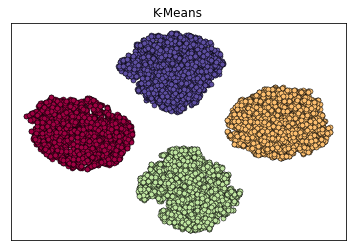

Elapsed Time: 22.116266012191772


In [11]:
start =time.time()
df = pd.read_csv('./data/data_final.csv')
df = df.iloc[:,1:]
model = k_clustering(df, 2)
#parameter = "linear" or "conv"
# optimal_num_cluster = model.optimize_clustering('conv')
optimal_num_cluster = 4
labels, medoids = model.k_means_clustering(optimal_num_cluster, "conv")
print("Elapsed Time:", time.time() - start)

### Addition of Extra Label for One Non-clustered Element

In [12]:
labels = np.append(labels,4)

## Group Each Cluster Data and Create csv File

In [13]:
df['Label'] = labels
account = pd.read_csv('./data/data_final.csv')
account = account.iloc[:,:1]
df.insert(loc=0, column='account_number', value=account[account.columns[0]])
print(df)
df.to_csv('./data/data_final_after_labeling.csv')

cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

center0 = []
center1 = []
center2 = []
center3 = []

for idx in range(len(df)):
    if df.values[idx][-1] == 0:
        cluster0.append(df.values[idx])
        
        if idx == medoids[0]:
            center0.append(0)
        else:
            center0.append(np.nan)        
        
    if df.values[idx][-1] == 1:
        cluster1.append(df.values[idx])
        
        if idx == medoids[1]:
            center1.append(1)
        else:
            center1.append(np.nan)        
        
    if df.values[idx][-1] == 2:
        cluster2.append(df.values[idx])
        
        if idx == medoids[2]:
            center2.append(2)
        else:
            center2.append(np.nan)        
        
    if df.values[idx][-1] == 3:
        cluster3.append(df.values[idx])

        if idx == medoids[3]:
            center3.append(3)
        else:
            center3.append(np.nan)


df0 = pd.DataFrame(cluster0)
df1 = pd.DataFrame(cluster1)
df2 = pd.DataFrame(cluster2)
df3 = pd.DataFrame(cluster3)


df0.columns = df.columns
df1.columns = df.columns
df2.columns = df.columns
df3.columns = df.columns


df0['Center'] = center0
df1['Center'] = center1
df2['Center'] = center2
df3['Center'] = center3
# print(df0)


# df0.to_csv('./cluster0.csv')
# df1.to_csv('./cluster1.csv')
# df2.to_csv('./cluster2.csv')
# df3.to_csv('./cluster3.csv')

      account_number  access_count  SEX_F  SEX_M  age_group  income_group  \
0             0.0000           1.0      0      1      0.375           0.0   
1             0.0001           1.0      0      1      0.750           0.0   
2             0.0002           0.2      0      1      0.500           0.0   
3             0.0003           0.6      0      1      0.625           0.0   
4             0.0005           0.0      1      0      1.000           0.0   
...              ...           ...    ...    ...        ...           ...   
8784          0.9994           1.0      1      0      0.625           0.0   
8785          0.9995           0.2      0      1      0.125           0.0   
8786          0.9996           1.0      1      0      0.250           0.0   
8787          0.9999           1.0      1      0      0.250           0.0   
8788          1.0000           0.8      1      0      0.500           0.0   

      account_age  LIFESTAGE_1  LIFESTAGE_2  LIFESTAGE_3  ...  kr_stock_yn 

In [14]:
df0.to_csv('./data/FBA_cluster1.csv')
df1.to_csv('./data/FBA_cluster2.csv')
df2.to_csv('./data/FBA_cluster3.csv')
df3.to_csv('./data/FBA_cluster4.csv')

## Descriptive Statistics & EDA for Finding Insights of Clusters





In [7]:
df_c1 = pd.read_csv('./data/FBA_cluster1.csv', index_col = 0)
df_c2 = pd.read_csv('./data/FBA_cluster2.csv', index_col = 0)
df_c3 = pd.read_csv('./data/FBA_cluster3.csv', index_col = 0)
df_c4 = pd.read_csv('./data/FBA_cluster4.csv', index_col = 0)

In [8]:
profile_c1 = ProfileReport(df_c1, title="Report")
profile_c2 = ProfileReport(df_c2, title="Report")
profile_c3 = ProfileReport(df_c3, title="Report")
profile_c4 = ProfileReport(df_c4, title="Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\ISCHOI\AppData\Roaming\Python\Python39\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
C:\Users\ISCHOI\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (51).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\ISCHOI\AppData\Roaming\Python\Python39\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
C:\Users\ISCHOI\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (51).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\ISCHOI\AppData\Roaming\Python\Python39\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
C:\Users\ISCHOI\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (51).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\ISCHOI\AppData\Roaming\Python\Python39\site-packages\missingno\missingno.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(
C:\Users\ISCHOI\AppData\Roaming\Python\Python39\site-packages\pandas_profiling\model\missing.py:89: UserWarning: There was an attempt to generate the Count missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Count": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (51).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

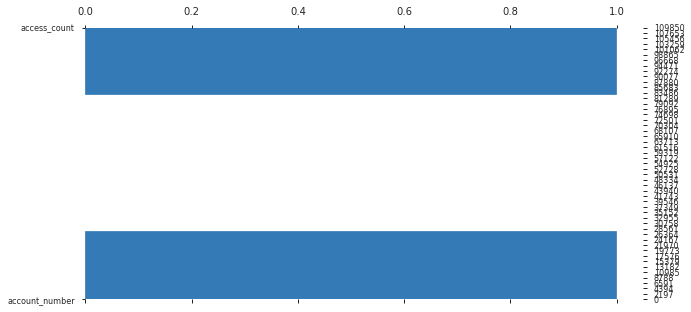

In [9]:
profile_c1.to_file("./data/cluster_profiles/cluster_1.html")
profile_c2.to_file("./data/cluster_profiles/cluster_2.html")
profile_c3.to_file("./data/cluster_profiles/cluster_3.html")
profile_c4.to_file("./data/cluster_profiles/cluster_4.html")